In [1]:
import geopandas as gpd
import pandas as pd
import asf_search as asf
from shapely.geometry import Polygon, shape
import datetime
from tqdm import tqdm
from rasterio.crs import CRS
import warnings
from datetime import timezone
import matplotlib.pyplot as plt
from dswx_verification.val_db import get_localized_validation_table, get_classified_planet_table

In [2]:
df_val = get_localized_validation_table()

def extract_acq_time(planet_id: str):
    tokens = planet_id.split('_')
    date_token = tokens[0]
    time_token = tokens[1]
    acq_time = datetime.datetime(int(date_token[:4]),
                                 int(date_token[4:6]),
                                 int(date_token[6:8]),
                                 int(time_token[:2]),
                                 int(time_token[2:4]),
                                 int(time_token[4:6]))
    return acq_time
df_val['planet_acq_time'] = df_val['planet_id'].map(extract_acq_time)
df_val.head()

,site_name,planet_id,dswx_hls_id,hls_id,dswx_hls_urls,validation_dataset_url,water_stratum,rel_local_val_path,rel_local_dswx_paths,geometry,planet_acq_time
0,4_9,20210914_103644_25_2413,OPERA_L3_DSWx-HLS_T32VMK_20210914T103629Z_2023...,HLS.S30.T32VMK.2021257T103629.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-calval-database-dswx.s3.us-west-...,3.0,4_9/site_name-4_9-classified_planet-20210914_1...,4_9/dswx/OPERA_L3_DSWx-HLS_T32VMK_20210914T103...,"POLYGON ((8.37742 58.56772, 8.37742 58.62217, ...",2021-09-14 10:36:44
1,4_8,20210912_034049_22_2421,OPERA_L3_DSWx-HLS_T47ULQ_20210911T043701Z_2023...,HLS.S30.T47ULQ.2021254T043701.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-calval-database-dswx.s3.us-west-...,3.0,4_8/site_name-4_8-classified_planet-20210912_0...,4_8/dswx/OPERA_L3_DSWx-HLS_T47ULQ_20210911T043...,"POLYGON ((97.58389 49.35489, 97.58389 49.40992...",2021-09-12 03:40:49
2,4_7,20211022_175213_55_2440,OPERA_L3_DSWx-HLS_T12VWP_20211021T185429Z_2023...,HLS.S30.T12VWP.2021294T185429.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-calval-database-dswx.s3.us-west-...,3.0,4_7/site_name-4_7-classified_planet-20211022_1...,4_7/dswx/OPERA_L3_DSWx-HLS_T12VWP_20211021T185...,"POLYGON ((-110.72351 61.77482, -110.72351 61.8...",2021-10-22 17:52:13
3,4_6,20210924_133812_95_2420,OPERA_L3_DSWx-HLS_T22UCU_20210923T142337Z_2023...,HLS.L30.T22UCU.2021266T142337.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-calval-database-dswx.s3.us-west-...,3.0,4_6/site_name-4_6-classified_planet-20210924_1...,4_6/dswx/OPERA_L3_DSWx-HLS_T22UCU_20210923T142...,"POLYGON ((-53.05215 48.61356, -53.05215 48.670...",2021-09-24 13:38:12
4,4_5,20210916_010848_94_2407,OPERA_L3_DSWx-HLS_T55TCJ_20210916T011649Z_2023...,HLS.S30.T55TCJ.2021259T011649.v2.0,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-calval-database-dswx.s3.us-west-...,3.0,4_5/site_name-4_5-classified_planet-20210916_0...,4_5/dswx/OPERA_L3_DSWx-HLS_T55TCJ_20210916T011...,"POLYGON ((145.11328 43.70883, 145.11328 43.800...",2021-09-16 01:08:48


In [3]:
def get_results_and_format(validation_footprint: Polygon, 
                           validation_date_acq: datetime.datetime,
                           planet_id: str,
                           window_days: int = 12):
    
    validation_date_acq = validation_date_acq.replace(tzinfo=timezone.utc)
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=validation_footprint.wkt,
                         maxResults=100,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=(validation_date_acq - datetime.timedelta(days=window_days)),
                         end=(validation_date_acq + datetime.timedelta(days=window_days))
                         )
    
    geometry = [shape(r.geojson()['geometry']) for r in res]
    data = [r.properties for r in res]

    df_res = pd.DataFrame(data)
    df_res = gpd.GeoDataFrame(df_res,
                              geometry=geometry,
                              crs=CRS.from_epsg(4326))
    if not df_res.empty:
        df_res['planet_id'] = planet_id
        df_res['startTime'] = pd.to_datetime(df_res['startTime'])
        
        df_res.sort_values(by=['pathNumber','startTime'], inplace=True)
        julian_dates = df_res.startTime.map(lambda dt: dt.to_julian_date())
        ## Note this calculus depends on the repeat pass frequency of Sentinel-1 which is 6
        df_res['repeat_pass_id'] = ((julian_dates - julian_dates[0]) // 5).astype(int)
        df_res = df_res.dissolve(by=['repeat_pass_id', 'pathNumber'], aggfunc='first').reset_index(drop=False)
        
        total_seconds = (df_res['startTime'] - validation_date_acq).dt.total_seconds()
        df_res['acq_delta_hours'] = total_seconds / (60**2)
        df_res['acq_delta_days'] = df_res['acq_delta_hours'] / 24
        df_res['acq_delta_hours_abs'] = df_res['acq_delta_hours'].abs()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            overlap_area = df_res['geometry'].intersection(validation_footprint).area
            df_res['overlap_percentage'] = (overlap_area / validation_footprint.area ) * 100
        df_res.sort_values(by=['acq_delta_hours_abs', 'overlap_percentage'], inplace=True)
        df_res = df_res.reset_index(drop=True)
    return df_res

## Multithreaded

In [29]:
import concurrent.futures

_, data_dicts = zip(*list(df_val.iterrows()))

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    dfs = list(tqdm(executor.map(lambda data: get_results_and_format(data['geometry'], 
                                                                     data['planet_acq_time'],
                                                                     data['planet_id']), 
                                 data_dicts), 
                    total=len(data_dicts)))

100%|██████████████| 52/52 [00:10<00:00,  4.99it/s]


In [30]:
dfs[0].columns

Index(['repeat_pass_id', 'pathNumber', 'geometry', 'beamModeType', 'browse',
       'bytes', 'centerLat', 'centerLon', 'faradayRotation', 'fileID',
       'flightDirection', 'groupID', 'granuleType', 'insarStackId', 'md5sum',
       'offNadirAngle', 'orbit', 'platform', 'pointingAngle', 'polarization',
       'processingDate', 'processingLevel', 'sceneName', 'sensor', 'startTime',
       'stopTime', 'url', 'fileName', 'frameNumber', 'planet_id',
       'acq_delta_hours', 'acq_delta_days', 'acq_delta_hours_abs',
       'overlap_percentage'],
      dtype='object')

In [31]:
df_s1 = pd.concat(dfs, axis=0).reset_index(drop=True)
df_s1.shape

(210, 34)

Include water stratum

In [32]:
df_s1 = pd.merge(df_val[['planet_id', 'water_stratum']], df_s1, on='planet_id', how='right')
print(df_s1.shape)
df_s1.head()

(210, 35)


,planet_id,water_stratum,repeat_pass_id,pathNumber,geometry,beamModeType,browse,bytes,centerLat,centerLon,...,sensor,startTime,stopTime,url,fileName,frameNumber,acq_delta_hours,acq_delta_days,acq_delta_hours_abs,overlap_percentage
0,20210914_103644_25_2413,3.0,-3.0,139.0,"POLYGON ((11.73264 56.89549, 12.39452 58.49953...",IW,None,3.684425e+09,57.9306,9.8869,...,C-SAR,2021-09-14 05:39:49+00:00,2021-09-14T05:40:16.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,S1B_IW_SLC__1SDV_20210914T053949_20210914T0540...,399.0,-4.948611,-0.206192,4.948611,100.000000
1,20210914_103644_25_2413,3.0,-3.0,44.0,"POLYGON ((7.38857 58.72607, 8.05488 57.12395, ...",IW,None,3.793971e+09,58.1570,9.8990,...,C-SAR,2021-09-13 17:02:17+00:00,2021-09-13T17:02:44.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210913T170217_20210913T1702...,187.0,-17.574167,-0.732257,17.574167,100.000000
2,20210914_103644_25_2413,3.0,-3.0,37.0,"POLYGON ((10.11510 58.10732, 10.80897 59.70935...",IW,None,4.417766e+09,59.1422,8.2297,...,C-SAR,2021-09-13 05:48:24+00:00,2021-09-13T05:48:51.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210913T054824_20210913T0548...,395.0,-28.805556,-1.200231,28.805556,100.000000
3,20210914_103644_25_2413,3.0,-3.0,117.0,"POLYGON ((4.91370 59.64262, 5.60713 58.04212, ...",IW,None,4.397028e+09,59.0780,7.5014,...,C-SAR,2021-09-12 17:10:04+00:00,2021-09-12T17:10:31.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,S1B_IW_SLC__1SDV_20210912T171004_20210912T1710...,190.0,-41.444444,-1.726852,41.444444,100.000000
4,20210914_103644_25_2413,3.0,-3.0,110.0,"POLYGON ((7.95638 57.73010, 8.64183 59.33296, ...",IW,None,4.087076e+09,58.7670,6.0717,...,C-SAR,2021-09-12 05:56:02+00:00,2021-09-12T05:56:29.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,S1B_IW_SLC__1SDV_20210912T055602_20210912T0556...,396.0,-52.678333,-2.194931,52.678333,50.915451


Remove small overlaps

In [33]:
MINIMUM_OVERLAP_THRESHOLD = 90
if True:
    ind = df_s1['overlap_percentage'] > 90
    df_s1 = df_s1[ind].reset_index(drop=True)

In [34]:
df_s1.head()

,planet_id,water_stratum,repeat_pass_id,pathNumber,geometry,beamModeType,browse,bytes,centerLat,centerLon,...,sensor,startTime,stopTime,url,fileName,frameNumber,acq_delta_hours,acq_delta_days,acq_delta_hours_abs,overlap_percentage
0,20210914_103644_25_2413,3.0,-3.0,139.0,"POLYGON ((11.73264 56.89549, 12.39452 58.49953...",IW,None,3.684425e+09,57.9306,9.8869,...,C-SAR,2021-09-14 05:39:49+00:00,2021-09-14T05:40:16.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,S1B_IW_SLC__1SDV_20210914T053949_20210914T0540...,399.0,-4.948611,-0.206192,4.948611,100.0
1,20210914_103644_25_2413,3.0,-3.0,44.0,"POLYGON ((7.38857 58.72607, 8.05488 57.12395, ...",IW,None,3.793971e+09,58.1570,9.8990,...,C-SAR,2021-09-13 17:02:17+00:00,2021-09-13T17:02:44.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210913T170217_20210913T1702...,187.0,-17.574167,-0.732257,17.574167,100.0
2,20210914_103644_25_2413,3.0,-3.0,37.0,"POLYGON ((10.11510 58.10732, 10.80897 59.70935...",IW,None,4.417766e+09,59.1422,8.2297,...,C-SAR,2021-09-13 05:48:24+00:00,2021-09-13T05:48:51.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210913T054824_20210913T0548...,395.0,-28.805556,-1.200231,28.805556,100.0
3,20210914_103644_25_2413,3.0,-3.0,117.0,"POLYGON ((4.91370 59.64262, 5.60713 58.04212, ...",IW,None,4.397028e+09,59.0780,7.5014,...,C-SAR,2021-09-12 17:10:04+00:00,2021-09-12T17:10:31.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,S1B_IW_SLC__1SDV_20210912T171004_20210912T1710...,190.0,-41.444444,-1.726852,41.444444,100.0
4,20210914_103644_25_2413,3.0,-2.0,117.0,"POLYGON ((5.24433 58.93230, 5.91616 57.33086, ...",IW,None,4.164381e+09,58.3638,7.7658,...,C-SAR,2021-09-18 17:10:34+00:00,2021-09-18T17:11:01.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210918T171034_20210918T1711...,188.0,102.563889,4.273495,102.563889,100.0


In [35]:
df_s1_first = df_s1.groupby(['planet_id'])[['acq_delta_days','overlap_percentage', 'geometry', 'pathNumber', 'fileID', 'water_stratum']].first()
df_s1_first = gpd.GeoDataFrame(df_s1_first, geometry=df_s1_first.geometry, crs=CRS.from_epsg(4326)).reset_index(drop=False)
df_s1_first.head()

,planet_id,acq_delta_days,overlap_percentage,geometry,pathNumber,fileID,water_stratum
0,20210903_150800_60_2458,-0.686875,100.0,"POLYGON ((-75.86066 56.10256, -75.25719 54.489...",62.0,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,3.0
1,20210903_152641_60_105c,1.288623,100.0,"POLYGON ((-71.49984 55.57276, -67.49414 55.979...",91.0,S1A_IW_SLC__1SDV_20210904T222218_20210904T2222...,3.0
2,20210904_093422_44_1065,3.328356,100.0,"POLYGON ((16.88950 -29.53718, 17.36622 -31.148...",131.0,S1A_IW_SLC__1SDV_20210907T172712_20210907T1727...,1.0
3,20210906_101112_28_225a,0.321944,100.0,"POLYGON ((-1.78026 43.13633, -1.33798 41.46041...",30.0,S1B_IW_SLC__1SDV_20210906T175448_20210906T1755...,2.0
4,20210909_000649_94_222b,-0.168854,100.0,"POLYGON ((140.14239 -31.87752, 140.65891 -30.1...",60.0,S1B_IW_SLC__1SDV_20210908T200340_20210908T2004...,1.0


Put in water stratum

In [36]:
df_val.columns

Index(['site_name', 'planet_id', 'dswx_hls_id', 'hls_id', 'dswx_hls_urls',
       'validation_dataset_url', 'water_stratum', 'rel_local_val_path',
       'rel_local_dswx_paths', 'geometry', 'planet_acq_time'],
      dtype='object')

In [37]:
df_s1 = pd.merge(df_val[['planet_id', 'water_stratum']], df_s1, on='planet_id')
df_s1.head()

,planet_id,water_stratum_x,water_stratum_y,repeat_pass_id,pathNumber,geometry,beamModeType,browse,bytes,centerLat,...,sensor,startTime,stopTime,url,fileName,frameNumber,acq_delta_hours,acq_delta_days,acq_delta_hours_abs,overlap_percentage
0,20210914_103644_25_2413,3.0,3.0,-3.0,139.0,"POLYGON ((11.73264 56.89549, 12.39452 58.49953...",IW,None,3.684425e+09,57.9306,...,C-SAR,2021-09-14 05:39:49+00:00,2021-09-14T05:40:16.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,S1B_IW_SLC__1SDV_20210914T053949_20210914T0540...,399.0,-4.948611,-0.206192,4.948611,100.0
1,20210914_103644_25_2413,3.0,3.0,-3.0,44.0,"POLYGON ((7.38857 58.72607, 8.05488 57.12395, ...",IW,None,3.793971e+09,58.1570,...,C-SAR,2021-09-13 17:02:17+00:00,2021-09-13T17:02:44.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210913T170217_20210913T1702...,187.0,-17.574167,-0.732257,17.574167,100.0
2,20210914_103644_25_2413,3.0,3.0,-3.0,37.0,"POLYGON ((10.11510 58.10732, 10.80897 59.70935...",IW,None,4.417766e+09,59.1422,...,C-SAR,2021-09-13 05:48:24+00:00,2021-09-13T05:48:51.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210913T054824_20210913T0548...,395.0,-28.805556,-1.200231,28.805556,100.0
3,20210914_103644_25_2413,3.0,3.0,-3.0,117.0,"POLYGON ((4.91370 59.64262, 5.60713 58.04212, ...",IW,None,4.397028e+09,59.0780,...,C-SAR,2021-09-12 17:10:04+00:00,2021-09-12T17:10:31.000Z,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,S1B_IW_SLC__1SDV_20210912T171004_20210912T1710...,190.0,-41.444444,-1.726852,41.444444,100.0
4,20210914_103644_25_2413,3.0,3.0,-2.0,117.0,"POLYGON ((5.24433 58.93230, 5.91616 57.33086, ...",IW,None,4.164381e+09,58.3638,...,C-SAR,2021-09-18 17:10:34+00:00,2021-09-18T17:11:01.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210918T171034_20210918T1711...,188.0,102.563889,4.273495,102.563889,100.0


# Visualize

<Axes: >

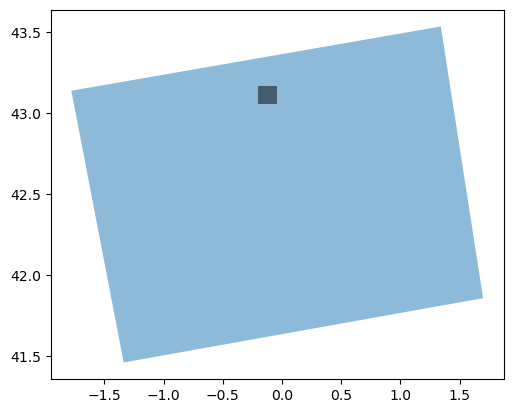

In [38]:
PLANET_ID = '20210906_101112_28_225a'

fig, ax = plt.subplots()

df_s1_first[df_s1_first.planet_id == PLANET_ID].plot(ax=ax, alpha=.5)
df_val[df_val.planet_id == PLANET_ID].plot(ax=ax, color='black', alpha=.5)

<Axes: >

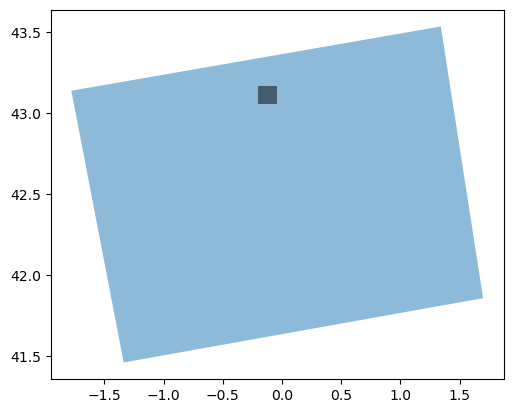

In [39]:
IMAGE_NAME = '20210928_141837_16_2407'

fig, ax = plt.subplots()

df_s1_first[df_s1_first.planet_id == PLANET_ID].plot(ax=ax, alpha=.5)
df_val[df_val.planet_id == PLANET_ID].plot(ax=ax, color='black', alpha=.5)

Shows histogram by water stratum.

array([[<Axes: title={'center': '0.0'}>, <Axes: title={'center': '1.0'}>],
       [<Axes: title={'center': '2.0'}>, <Axes: title={'center': '3.0'}>]],
      dtype=object)

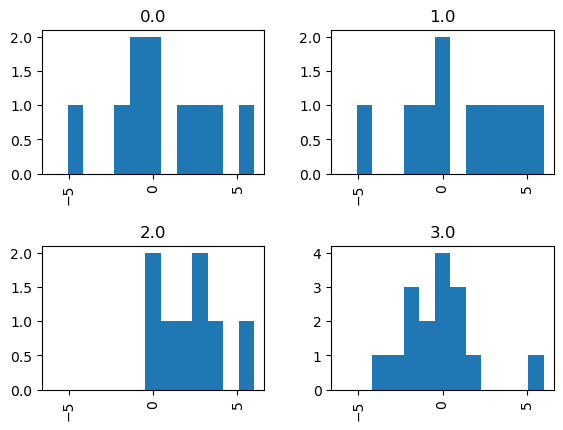

In [40]:
df_s1_first.hist('acq_delta_days', by='water_stratum', range=(-6, 6), bins=13)

Text(0, 0.5, '# of S1 Images (closest occuring)')

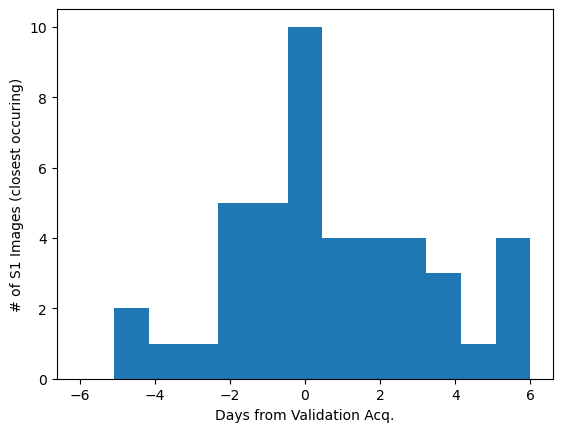

In [41]:
plt.hist(df_s1_first.acq_delta_days.values, range=(-6, 6), bins=13)
plt.xlabel('Days from Validation Acq.')
plt.ylabel('# of S1 Images (closest occuring)')

In [42]:
df_s1_first['overlap_percentage_r'] = df_s1_first.overlap_percentage.round()
df_s1_first.sort_values(by='overlap_percentage_r', inplace=True)
df_s1_first[['planet_id', 'overlap_percentage_r']].head()

,planet_id,overlap_percentage_r
0,20210903_150800_60_2458,100.0
24,20210928_141837_16_2407,100.0
25,20210929_073913_09_2453,100.0
26,20210930_070548_00_2442,100.0
27,20211002_155415_1009,100.0


In [49]:
ids = df_s1_first.fileID.tolist()
ids = [id_[:-4] for id_ in ids]
with open('s1_ids_for_val.txt', 'w') as f:
    f.write('\n'.join(ids))